# Сравнение оценивания логотипов двух компаний

Решаемые задачи

Подтвердите или опровергните следующие гипотезы:
- распределение оценок логотипа X можно описать как нормальное
- логотип компании Y в среднем оценивают значимо выше, чем логотип компании X
- нет никакой зависимости между оценкой логотипа X и возрастом респондентов

## Импорт библиотек

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
plt.style.use('dark_background')

## Загрузка данных и предварительный просмотр

In [2]:
try:
    data = pd.read_excel('marketplaces.xlsx', header=1,
                         names=['number', 'x_scores', 'y_scores', 'age_group'])
except:
    print('Добавь файл с данными в текущую папку (где открыт файл ноутбука)')

In [3]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   number     1469 non-null   float64
 1   x_scores   1203 non-null   object 
 2   y_scores   1203 non-null   object 
 3   age_group  1469 non-null   object 
dtypes: float64(1), object(3)
memory usage: 46.0+ KB


,number,x_scores,y_scores,age_group
0,1.0,Ни разу не видел(-а),Ни разу не видел(-а),25 - 34 года
1,2.0,4.0,7.0,18 - 24 года
2,3.0,9.0,Ни разу не видел(-а),25 - 34 года
3,4.0,7.0,7.0,35 - 45 лет
4,6.0,8.0,9.0,25 - 34 года
5,7.0,Ни разу не видел(-а),10.0,25 - 34 года
6,8.0,9.0,7.0,18 - 24 года
7,9.0,10.0,10.0,25 - 34 года
8,10.0,9.0,9.0,35 - 45 лет
9,11.0,Ни разу не видел(-а),Ни разу не видел(-а),25 - 34 года


## Предобработка

Больше 200 строк с пропусками в столбцах с оценками логотипов. Они нам явно не нужны.

Также для анализа распределений портят картину значения "Ни разу не видел(-а)".

Создадим "чистый" датафрейм, без пропусков в колонках с оценками и без статуса "не видел(а)" 

In [4]:
df = data.loc[(data['x_scores'] != 'Ни разу не видел(-а)') &
              (data['y_scores'] != 'Ни разу не видел(-а)') &
              (~ data['x_scores'].isnull()) &
              (~ data['y_scores'].isnull())]
df

,number,x_scores,y_scores,age_group
1,2.0,4.0,7.0,18 - 24 года
3,4.0,7.0,7.0,35 - 45 лет
4,6.0,8.0,9.0,25 - 34 года
6,8.0,9.0,7.0,18 - 24 года
7,9.0,10.0,10.0,25 - 34 года
...,...,...,...,...
1197,290.0,10.0,10.0,35 - 45 лет
1198,291.0,9.0,9.0,35 - 45 лет
1200,293.0,10.0,10.0,35 - 45 лет
1201,294.0,10.0,7.0,35 - 45 лет


Зададимся вопросом много ли таких людей, кто видел логотип одной компании и не видел другой, чтобы понимать, насколько много данных мы потеряли (не считая строки, где в оценках вообще были пропуски).

In [5]:
shape_only_score = data.loc[((data['x_scores'] != 'Ни разу не видел(-а)') &
              (data['y_scores'] == 'Ни разу не видел(-а)')) |
        ((data['y_scores'] != 'Ни разу не видел(-а)') &
              (data['x_scores'] == 'Ни разу не видел(-а)'))].shape[0]

In [6]:
shape_only_score / (shape_only_score + df.shape[0])

0.15217391304347827

В целом теряем не так много данных, поэтому можем отказаться от них.

P.S. Другим вероятным вариантом будет приравнять значение  "не видел(а)" среднему значению по выборке. Однако мы считаем это не совсем справедливым фактом в данном случае.

In [7]:
df['x_scores'] = df['x_scores'].astype('int16')
df['y_scores'] = df['y_scores'].astype('int16')
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   number     936 non-null    float64
 1   x_scores   936 non-null    int16  
 2   y_scores   936 non-null    int16  
 3   age_group  936 non-null    object 
dtypes: float64(1), int16(2), object(1)
memory usage: 18.4+ KB


## Проверка распределения оценок логотипа X на нормальность данных

Одновременно посмотрим и на данные по логотипу Y.

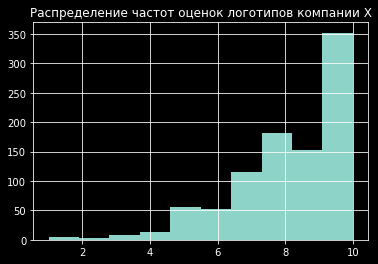

In [8]:
df['x_scores'].hist()
plt.title('Распределение частот оценок логотипов компании Х')
plt.show()

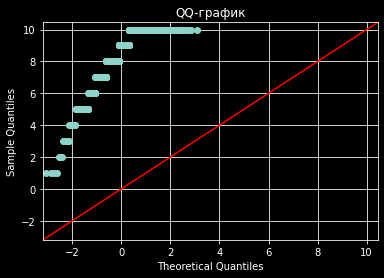

In [18]:
fig = sm.qqplot (df['x_scores'], line='45')
plt.grid(True)
plt.title('QQ-график')
plt.show()

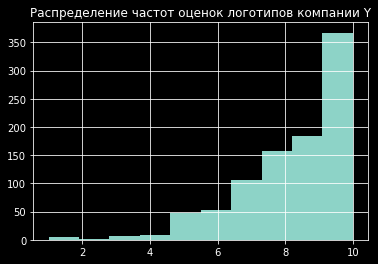

In [10]:
df['y_scores'].hist()
plt.title('Распределение частот оценок логотипов компании Y')
plt.show()

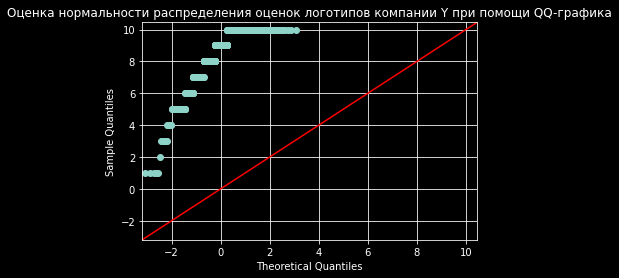

In [11]:
fig = sm.qqplot (df['y_scores'], line='45')
plt.grid(True)
plt.title('Оценка нормальности распределения оценок логотипов компании Y при помощи QQ-графика')
plt.show()

"Не верим глазам - проверим цифрами". Выполним тест Колмогорова-Смирнова. Если  pvalue в нем меньше порогового значения ("альфа" - во всех расчетах ниже примем равное 5%), это нам будет говорить, что соответствие между нашей выборкой и нормальным распределением отсутствует.

In [12]:
kstest(df['x_scores'], 'norm')

KstestResult(statistic=0.9911714694897374, pvalue=0.0)

In [13]:
kstest(df['y_scores'], 'norm')

KstestResult(statistic=0.9922398455581135, pvalue=0.0)

Очевидный вывод по обеим выборкам оценок: распределения не нормальные (назовем его в данном случае линейным), о чем нам говорит визуальный анализ (гистограммы неколоколовидные, на QQ-графике данные наших распределений не лежат на крсаной прямой) и количественный.

Также отметим, схожесть обеих выборок, что важно для следующего задания.

## Предположение о более высоких оценках компании Y, в сравнении с оценками компании X

Сформулируем нулевую гипотезу (H0):
- средние значения оценок логотипов компаний Y и Х одинаковые.

Тогда альтернативная гипотеза (H1):
- средние значения оценок логотипов компаний Y и Х различаются.

Предполагаем, что оценки логотипов не зависят друг от друга, а распределения схожи (пусть и ненормальные).

In [21]:
x_score = df['x_scores'].values
y_score = df['y_scores'].values
alpha = .05

results = st.ttest_ind(x_score, y_score, equal_var = False)

print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Можем отвергнуть Н0')
else:
    print('Нельзя отвергнуть Н0')


р-значение: 0.11055297535554891
Нельзя отвергнуть Н0


Очевидно, что p-value очень высокое и означает, что примерно в 11% случаев произойдет так, как гласит нулевая гипотеза и отвергнуть ее мы не можем. Для потвержедения этого взглянем на сами средние значения выборок

In [15]:
print(x_score.mean())
print(y_score.mean())

8.35576923076923
8.485042735042734


Заметно, что разница немного более 0,1 балла. И это немного, что в общем подтверждает вышепроведенный тест.


## Изучение зависимости между оценкой логотипа компании Х и возрастом респондентов

Определять зависимость между оценкой логотипа X и возрастом респондентов было бы эффективнее (по крайней мере можно посмотреть коэффициент корреляции, построить график), зная точный возраст отдельного человека, однако у нас даны категории (вохрастные группы). Поэтому в общем случае можно сделать группировку и оценить расхождения.

In [16]:
x_scores_gb = df.groupby('age_group').agg({'x_scores': ['mean', 'count']})
x_scores_gb['delta_score_to_mean'] = x_score.mean() - x_scores_gb['x_scores']['mean']
x_scores_gb['age_index'] = [1, 2, 3]
x_scores_gb

x_scores       delta_score_to_mean age_index
                  mean count                              
age_group                                                 
18 - 24 года  8.462428   173           -0.106659         1
25 - 34 года  8.291080   426            0.064689         2
35 - 45 лет   8.382789   337           -0.027020         3

Очевидно, что как отклонения от среднего значения, так и просто различия средних значений по группам очень малы (в первом случае только чуть больше 0,1 по модулю). Кроме того, количество оценщиков в разных группах отличается. К примеру, в первой их достаточно мало, что и объясняет большее отклонение от общего среднего по выборке.

Можно действовать и более "количественным" образом: сравнить общее среднее по x_scores и средние по группам формулируя нулевую гипотезу вроде:
- общее среднее оценок логотипов компании Х равно среднему значению конкретной возрастной категории в этой выборке.

В целом это "притянутый за уши" подход, но попробовать его можно.

In [17]:
interested_value = [el for el in x_scores_gb['x_scores']['mean']]
i = 1
for el in interested_value:
    results = st.ttest_1samp( 
        x_score,
        el) 
    print('-' * 8, f'При сравнении среднего возрастной группы {i} и общего среднего', '-' * 8)
    print('р-значение:', results.pvalue)
    if results.pvalue < alpha:
        print('Можем отвергнуть Н0')
    else:
        print('Нельзя отвергнуть Н0')
    i += 1

-------- При сравнении среднего возрастной группы 1 и общего среднего --------
р-значение: 0.06755233131391898
Нельзя отвергнуть Н0
-------- При сравнении среднего возрастной группы 2 и общего среднего --------
р-значение: 0.26729436548123836
Нельзя отвергнуть Н0
-------- При сравнении среднего возрастной группы 3 и общего среднего --------
р-значение: 0.6430239002345084
Нельзя отвергнуть Н0


Т.е. по факту получаем, что средние значения по группам равны общему среднему по выборке и между собой отличаются незначимо.

## Выводы

- гипотеза о нормальности распределения оценок опрошенных не подтвердилась (распределения больше похожи на линейные). Причем это актуально для оценко по обеим компаниям;
- гипотеза о том, что логотип компании Y в среднем оценивают значимо выше, чем логотип компании X, не подтвердилась;
- зависимости между оценкой логотипа X и возрастом респондентов нет.